/opt/anaconda3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/anaconda3/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

<Figure size 2000x2000 with 0 Axes>

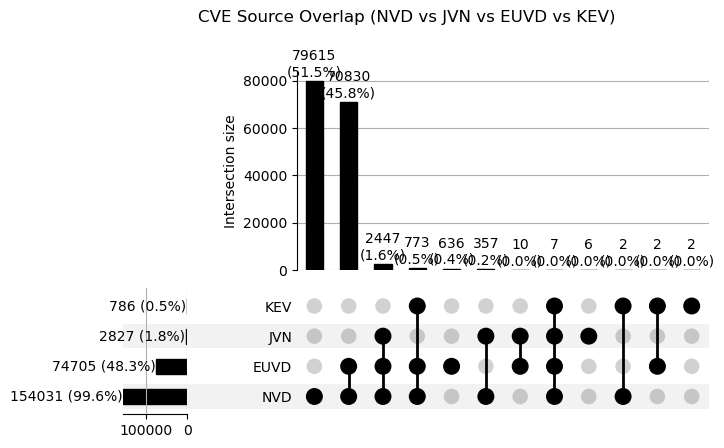

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators

df = pd.read_csv("/Users/kelvinguyen2/Documents/data/clean/combined_with_features.csv", low_memory=False)
expected = ["nvd_present", "jvn_present", "eu_present", "kev_present"]
missing = [c for c in expected if c not in df.columns]


# Clean types
for c in expected:
    df[c] = df[c].fillna(False).astype(bool)

df = df[df["cve_year"] >= 2021]
rename = {
    "nvd_present": "NVD",
    "jvn_present": "JVN",
    "eu_present": "EUVD",
    "kev_present": "KEV",
}

indicator_df = df[expected].rename(columns=rename)

upset_data = from_indicators(indicator_df.columns.tolist(), indicator_df)


plt.figure(figsize=(20, 20))
up = UpSet(
    upset_data,
    show_counts=True,
    show_percentages=True,
    sort_by="cardinality",   # sort intersections by size
)

up.plot()

plt.suptitle("CVE Source Overlap (NVD vs JVN vs EUVD vs KEV)", y=1.02)
plt.tight_layout()
plt.show()

# plt.savefig("source_overlap_upset.png", dpi=300, bbox_inches="tight")


/opt/anaconda3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/anaconda3/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

<Figure size 1400x800 with 0 Axes>

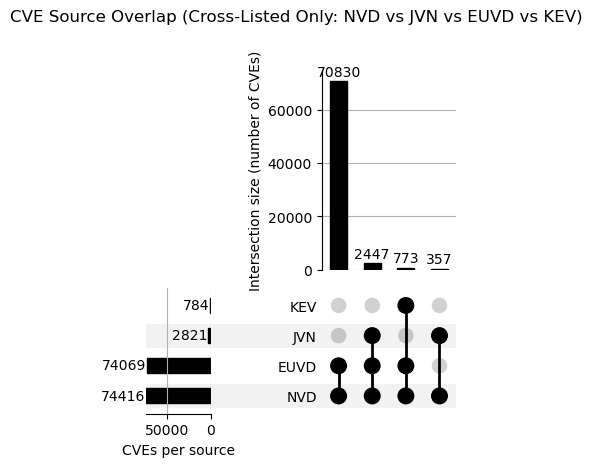

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators


df = pd.read_csv(
    "/Users/kelvinguyen2/Documents/data/clean/combined_with_features.csv",
    low_memory=False
)


for c in expected:
    df[c] = df[c].fillna(False).astype(bool)

df = df[df.get("cve_year", 0) >= 2021].copy()

df["source_count"] = df[expected].sum(axis=1)


df = df[df["source_count"] >= 2].copy()

rename = {
    "nvd_present": "NVD",
    "jvn_present": "JVN",
    "eu_present": "EUVD",
    "kev_present": "KEV",
}

indicator_df = df[expected].rename(columns=rename)

upset_data = from_indicators(indicator_df.columns.tolist(), indicator_df)


plt.figure(figsize=(14, 8))

up = UpSet(
    upset_data,
    show_counts=True,
    show_percentages=False,
    sort_by="cardinality",
    min_subset_size=50,   # hide tiny intersections (tune: 20, 50, 100)
)

axes = up.plot()


if isinstance(axes, dict):
    ax_int = axes.get("intersections", None)
    ax_tot = axes.get("totals", None)

    if ax_int is not None:
        ax_int.set_xlabel("Source combinations")
        ax_int.set_ylabel("Intersection size (number of CVEs)")

    if ax_tot is not None:
        ax_tot.set_xlabel("CVEs per source")
        ax_tot.set_ylabel("")

plt.suptitle(
    "CVE Source Overlap (Cross-Listed Only: NVD vs JVN vs EUVD vs KEV)",
    y=1.02
)
plt.tight_layout()
#plt.show()
plt.savefig("source_overlap_upset_cross_listed.png", dpi=300, bbox_inches="tight")


In [118]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_unlabeled_positive_demo(df: pd.DataFrame, cutoff_date: str = "2021-11-2", *, published_col: str = "published_date", kev_flag_col: str = "kev_present",kev_date_col: str = "kev_published",
):

    dff = df.copy()

    if published_col in dff.columns:
        dff[published_col] = pd.to_datetime(dff[published_col], errors="coerce", utc=True)
    if kev_date_col in dff.columns:
        dff[kev_date_col] = pd.to_datetime(dff[kev_date_col], errors="coerce", utc=True)

    if kev_flag_col not in dff.columns:
        src = dff.get("sources", "").fillna("").astype(str).str.upper()
        dff[kev_flag_col] = src.str.contains(r"\bKEV\b", regex=True)

    dff[kev_flag_col] = dff[kev_flag_col].fillna(False).astype(bool)

    cutoff = pd.Timestamp(cutoff_date, tz="UTC")

    # Cohort = CVEs that existed by the cutoff
    cohort = dff[
        dff[published_col].notna() & (dff[published_col] <= cutoff)
    ].copy()

    # Known positives as of cutoff
    known_by_cutoff = (
        cohort[kev_flag_col]
        & cohort[kev_date_col].notna()
        & (cohort[kev_date_col] <= cutoff)
    )

    # Unlabeled positives relative to cutoff:
    # these would have been labeled negative at the time
    future_after_cutoff = (
        cohort[kev_flag_col]
        & cohort[kev_date_col].notna()
        & (cohort[kev_date_col] > cutoff)
    )

    # Still not KEV as of latest pull
    still_not_kev = ~cohort[kev_flag_col]

    counts = {
        "Positive label at cutoff": int(known_by_cutoff.sum()),
        "Labeled negative\nbut later KEV": int(future_after_cutoff.sum()),
        "Labeled negative\nand still not KEV": int(still_not_kev.sum()),
    }

    total = sum(counts.values())
    labels = list(counts.keys())
    values = [counts[k] for k in labels]
    perc = [v / total * 100 if total else 0 for v in values]

    # Plot
    plt.figure(figsize=(9, 5))
    bars = plt.bar(labels, values)

    plt.title("Illustration of the Unlabeled Positive Problem (KEV)")
    plt.ylabel("Number of CVEs (published ≤ cutoff)")
    plt.xlabel("How CVEs would appear at the cutoff date")

    for b, v, p in zip(bars, values, perc):
        plt.text(
            b.get_x() + b.get_width() / 2,
            v,
            f"{v:,}\n({p:.2f}%)",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

    return counts


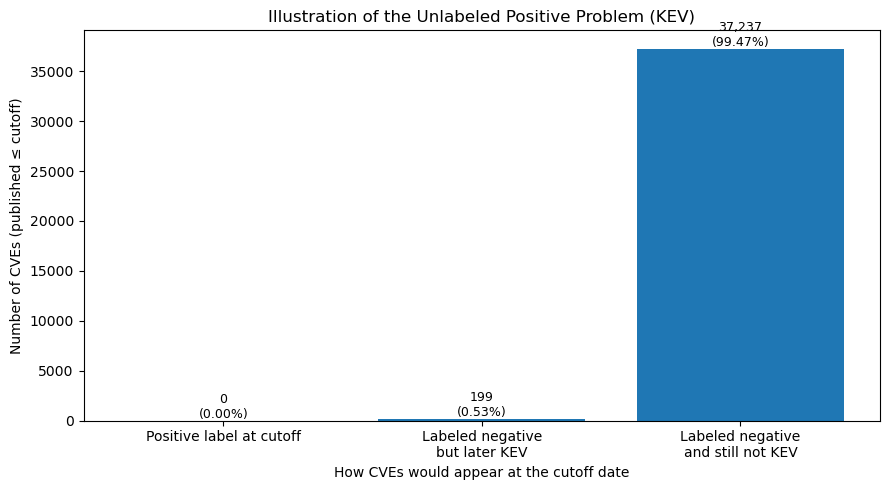

{'Positive label at cutoff': 0,
 'Labeled negative\nbut later KEV': 199,
 'Labeled negative\nand still not KEV': 37237}

In [120]:
df = pd.read_csv("/Users/kelvinguyen2/Documents/data/clean/combined_with_features.csv", low_memory=False)
plot_unlabeled_positive_demo(df)